## Pseudorandom numbers and Automatic differentiation

#### *25 September 2020*
#### *DATA 1010*

## Pseudorandom numbers

### Problem 1 

Consider the sequence $\{\mathrm{mod}(3\cdot2^n,11)\}_{n=1}^{100}$. Use Julia to show that each number from 1 to 10 appears exactly 10 times in this sequence. Also, use Julia to show that $a_{2k}$ is smaller than $a_{2k-1}$ for far more than half the values of $k$ from 1 to 50. Hint: `countmap(a)` tells you how many times each element in the collection `a` appears. To use this function, do `using StatsBase` first.

Repeat these tests on the sequence whose $k$th term is the $k$th digit in the decimal representation of $\pi$: `reverse(digits(floor(BigInt,big(10)^99*pi)))`. 

In [20]:
using StatsBase
a = [6]
for _ in 2:100
    push!(a, mod(2a[end],11))
end
countmap(a)
sum(a[2i] == a[2i-1] for i = 1:length(a)÷2)
a = rand(1:10,100)
sum(a[2i] < a[2i-1] for i = 1:length(a)÷2)

27

---

### Problem 2

Let $\phi = (1+\sqrt{5})/2$ be the golden ratio, and recall that the *fractional part* of a number $x$ is the difference between $x$ and the greatest integer less than or equal to $x$. Show that the sequence whose $k$th term is the fractional part of $\phi^k$ does not work well as a $\mathrm{Uniform}([0,1])$ pseudorandom number generator. 

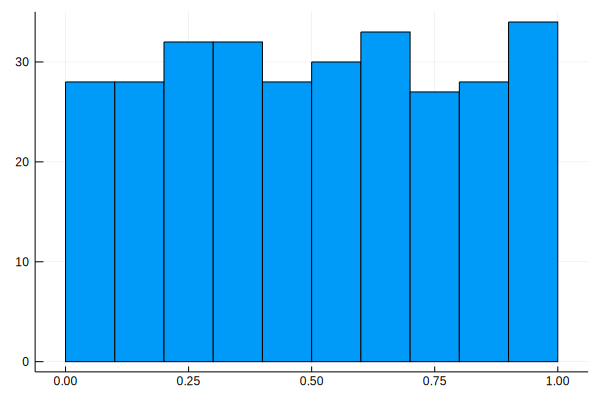

In [28]:
ϕ = MathConstants.φ
setprecision(10000)
using Plots
histogram([mod(big(ϕ)^k,1) for k in 1:30], legend = false, bins = 12)
histogram([mod(big(π)*k,1) for k in 1:300], legend = false, bins = 12)

## Automatic differentiation

### Problem 3 : Symbolic differentiation

The most familiar way to differentiate a function is to retain the **entire function** throughout all differentiation steps, by treating the input value as a symbolic quantity. 

Use the code cell below to evaluate the derivative of the function $f(x) = (x^4 - 2x^3 - x^2 + 3x - 1)e^{-x^4/4}$. 

In [30]:
using SymPy
f(t) = exp(-t^2/4)*(t^4 - 2t^3 - t^2 + 3t - 1)
@vars x
diff(f(x),x)

                                  2                                 
                                -x                                2 
                                ────                            -x  
    ⎛ 4      3    2          ⎞   4                              ────
  x⋅⎝x  - 2⋅x  - x  + 3⋅x - 1⎠⋅ℯ       ⎛   3      2          ⎞   4  
- ────────────────────────────────── + ⎝4⋅x  - 6⋅x  - 2⋅x + 3⎠⋅ℯ    
                  2                                                 

Now substitute $x = 2$ to find the derivative of $f$ at $x=2$.

In [36]:
true_derivative = Float64(diff(f(x),x)(x=>2))

2.207276647028654

---

### Problem 4: Difference quotients

Symbolic differentiation is typically not suitable for differentiating functions encountered in scientific computing (including machine learning), because the expression trees generated by substituting a symbolic variable into the function can grow very large very quickly. Consider the following small recursively defined function: 




In [33]:
function g(x, n)
    if n == 1
        x
    else
        g(x,n-1) + 1/g(x,n-1)
    end
end

@vars x
g(x,6)

                                  1                                           
x + ───────────────────────────────────────────────────────────── + ──────────
                      1                       1           1     1             
    x + ───────────────────────────── + ───────────── + ───── + ─   x + ──────
                  1           1     1         1     1       1   x             
        x + ───────────── + ───── + ─   x + ───── + ─   x + ─           x + ──
                  1     1       1   x           1   x       x                 
            x + ───── + ─   x + ─           x + ─                           x 
                    1   x       x               x                             
                x + ─                                                         
                    x                                                         

    1                       1           1     1
─────────────────── + ───────────── + ───── + ─
1           1     1         1     

The opposite approach to retaining the whole function through every step of the calculation is to retain the values only at a **single point** at a time, and recover the derivative using the approximation
$$
f'(x) \approx \frac{f(x+h) - f(x)}{h}.
$$

Approximate the derivative of $f(x) = (x^4 - 2x^3 - x^2 + 3x - 1)e^{-x^4/4}$ at $x = 2$ by computing and plotting difference quotients $(f(x+h)-f(x))/h$ for various values of $h$ (for example, the powers of $2$ from $2^{-60}$ to $2^{-20}$). What is the least error over these values of k? How does that error compare to machine epsilon?

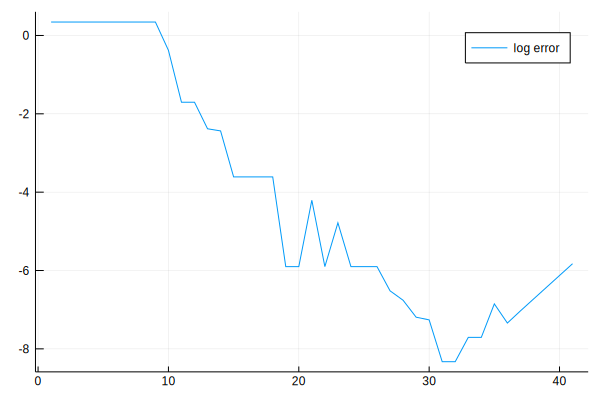

In [39]:
plot([log10(abs(true_derivative - (f(2+2.0^k)-f(2))/2.0^k)) for k = -60:-20], label = "log error")

---

### Problem 5: Autodiff  

Fortunately, there is an approach to differentiation that is both fast and accurate. The idea is to retain neither the whole function nor just the first term of the Taylor Series (that is, the function's value) through each step of the calculation, but rather the first **two** terms of the Taylor Series. 

We do this computationally by introducing a new object called a **dual number** which has two parts: the **value** and the **derivative**. You can think of a dual number as a tiny window into the graph of a function at a particular point. It allows you to see the function's value and how the graph is tilted there. 

<img src="autodiff.svg" width=100%>

We can define a new `DualNumber` object in Julia as follows:

```julia
struct DualNumber
    value::Real
    derivative::Real
end
```

If we want to find the derivative of a function at $x = 2$, we can substitute `DualNumber(2,1)` into $f$ and read off the derivative field of the resulting output. The catch here is that all functions used by $f$ must be taught how to behave on dual numbers.

Use automatic differentiation to find the derivative of $f(x) = (x^4 - 2x^3 - x^2 + 3x - 1)e^{-x^4/4}$ at the point $x = 2$. Compare your answer to the true value of $f'(2)$.
  



In [52]:
using LinearAlgebra
f(t) = exp(-t^2/4)*(t^4 - 2t^3 - t^2 + 3t - 1)

struct DualNumber
    value::Real
    derivative::Real
end

import Base: *, ^, +, -, /, exp

DualNumber(x::Real) = DualNumber(x,0)
-(x::DualNumber) = DualNumber(-x.value, -x.derivative)
+(x::DualNumber, y::DualNumber) = DualNumber(x.value + y.value, x.derivative + y.derivative)
-(x::DualNumber, y::DualNumber) = x + (-y)
-(x::DualNumber, y::Real) = x - DualNumber(y)
*(x::DualNumber, y::DualNumber) = DualNumber(x.value * y.value, 
                                             x.derivative * y.value + y.derivative * x.value)
*(x::Real, y::DualNumber) = DualNumber(x) * y
^(x::DualNumber, n::Integer) = Base.power_by_squaring(x, n)
/(x::Real, y::DualNumber) = DualNumber(x/y.value, -x*y.derivative/y.value^2)
/(x::DualNumber, y::DualNumber) = (1/y) * x
/(x::DualNumber, y::Real) = (1/y) * x

exp(x::DualNumber) = DualNumber(exp(x.value), exp(x.value) * x.derivative)

f(DualNumber(2,1))

DualNumber(0.36787944117144233, 2.207276647028654)

Compare the derivative obtained using autodiff to the value obtained by differentiating symbolically (at the bit level!): 

In [53]:
println(bitstring(Float64(diff(f(x),x)(x=>2)))) # symbolic differentiation
println(bitstring(f(DualNumber(2,1)).derivative)) # automatic differentiation

0100000000000001101010001000000010101000101000011011001101101010
0100000000000001101010001000000010101000101000011011001101101010
